In [6]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from chen_process import *

# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')

cohort.ix[cohort.age > 90, 'age']=90

urine = pd.read_csv(data_path+'urine.csv')
urine = urine.loc[urine['value'] < 5000]
urine = urine.loc[urine['min_from_intime'] >= 0]

maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')


In [7]:
# Interpolate the missing weights

cohort.set_index('icustay_id', inplace=True)
cohort = interpolateweights(cohort)

# Compute the urine blocks
aki_urine = calculateurineaki(urine, cohort)
cohort = pd.read_table(data_path+'cohort.tsv')

In [8]:
# Get ethnicities 
eth = geteth(cohort)

In [9]:
# clean the lactate
cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

In [10]:
# Get map features 
mean_maps, min_maps, map_fracs = getmapfeatures(maps)

Fraction of hours missing MAP values: 0.0727082162255


In [11]:
# Process creatinine values and calculate aki 
creat_summary = analyzecreatinine(creatinine, admission_creatinine)

In [12]:
# Get the logistic regression data
lr_data, aki_dataset, non_aki_dataset = getlrdata(cohort, eth, min_maps, creat_summary, aki_urine)

In [13]:
# Summarize results

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
               age          los  max_lactate    vaso_frac      min_map
count  2937.000000  2937.000000  2937.000000  2937.000000  2937.000000
mean     76.678879    13.006636     3.333398     0.159389    56.594029
std      55.182610    11.307988     2.805793     0.229111     8.744802
min      18.340391     3.001000     0.500000     0.000000    31.000000
25%      54.333847     5.360800     1.600000     0.000000    51.500000
50%      67.324983     9.376100     2.400000     0.043662    56.000000
75%      78.307719    16.349700     4.000000     0.243795    61.600000
max     309.777981   173.072500    27.700000     0.995077   102.000000

gender:
M    1502
F    1435
dtype: int64

M    0.511406
F    0.488594
dtype: float64

ethnicity:
WHITE                            2208
UNKNOWN                           344
BLACK/AFRICAN AMERICAN            194
HISPANIC/LATINO                    79
MULTI/OTHER                       

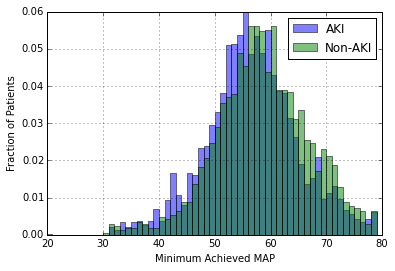

In [14]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

In [15]:
# Organize data for logistic regression

train_cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','min_map_bin']]
train_cols['gender'] = pd.Categorical(train_cols['gender'])
train_cols['eth'] = pd.Categorical(train_cols['eth'])
train_cols['min_map_bin'] = pd.Categorical(train_cols['min_map_bin'])

train_cols['gender'] = train_cols.gender.cat.codes
train_cols['eth'] = train_cols.eth.cat.codes
train_cols['min_map_bin'] = train_cols.min_map_bin.cat.codes

# Manually add the intercept
train_cols['intercept'] = 1.0

# Do logistic regression
logit = sm.Logit(lr_data['aki'], train_cols)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.618257
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    aki   No. Observations:                 4663
Model:                          Logit   Df Residuals:                     4655
Method:                           MLE   Df Model:                            7
Date:                Fri, 09 Dec 2016   Pseudo R-squ.:                 0.06187
Time:                        01:04:36   Log-Likelihood:                -2882.9
converged:                       True   LL-Null:                       -3073.1
                                        LLR p-value:                 4.002e-78
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
age             0.0036      0.001      5.095      0.000         0.002     0.005
gender         -0.0643    

In [16]:
# Get odds ratios
print np.exp(result.params)

age            1.003630
gender         0.937755
eth            1.082642
los            1.064030
max_lactate    1.046530
vaso_frac      1.772207
min_map_bin    0.827731
intercept      0.568357
dtype: float64


In [17]:
# The data split by the min_map_bin
mapgroups = []
akinums=np.zeros([7,3])
akimaptimes=[]

for binnum in range(0, 7):
    if binnum==6:
        binstring = '(90, 200]'
    else:
        binstring = '('+str(binnum+3)+'0, '+str(binnum+4)+'0]'
    mapgroup = lr_data.ix[lr_data.min_map_bin == binstring]
    mapgroups.append(mapgroup)
    
    akinums[binnum, 0]= mapgroup.loc[mapgroup['aki']==True].shape[0]
    akinums[binnum, 1] = mapgroup.shape[0] - akinums[binnum, 0]
    akinums[binnum, 2] = akinums[binnum,0]/mapgroup.shape[0]
    
    akimaptimes.append(mapgroup[['min_map', 'hour', 'tAKI']].dropna().values)


/Users/nalinisingh/dev/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


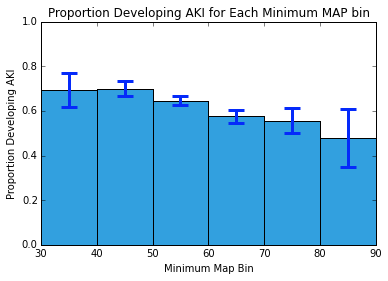

In [36]:
# Bar chart of fraction of patients developing AKI within 72 hours for each minimum MAP bin


akiprops=np.zeros([7,3])
for binnum in range(0,len(akimaptimes)):
    # First bootstrap the aki times
    binaries = np.append(np.ones(akinums[binnum,0]), np.zeros(akinums[binnum,1]))
    
    akiprops[binnum,:]= bootstrap_CI(binaries)
    
relativeerrors = akiprops[:,[0,2]].transpose()
for i in range(0,7):
    relativeerrors[:,i]=relativeerrors[:,i]-akiprops[i,1]
relativeerrors = abs(relativeerrors)
plt.bar(range(30, 81, 10), akinums[:-1,2], 10, color='#32A0DF')
(_, caps, _) = plt.errorbar(range(35, 86, 10), akinums[:-1,2], relativeerrors[:,:-1], ecolor='#052AFA', linestyle='none', 
                            elinewidth=3, capsize=8)
for cap in caps:
    cap.set_markeredgewidth(3)

plt.show

plt.xlabel('Minimum Map Bin')
plt.ylabel('Proportion Developing AKI')
plt.title('Proportion Developing AKI for Each Minimum MAP bin')
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,1])
plt.show()

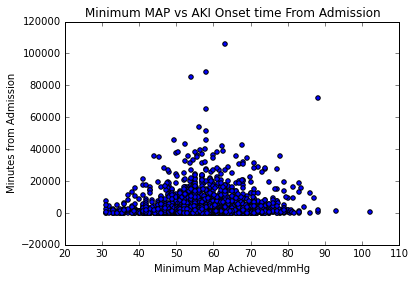

In [37]:
# Scatter plot of minimum map achieved to time of AKI development from admission
for i in range(0, len(akimaptimes)):
    plt.scatter(akimaptimes[i][:,0], akimaptimes[i][:,2]) # Non-binned lowest map
    #b=plt.scatter(len(akimaptimes[i])*[10*(i+3)], akimaptimes[i][:,1]) # Binned lowest map
plt.title('Minimum MAP vs AKI Onset time From Admission')
plt.xlabel('Minimum Map Achieved/mmHg')
plt.ylabel('Minutes from Admission')
plt.show()

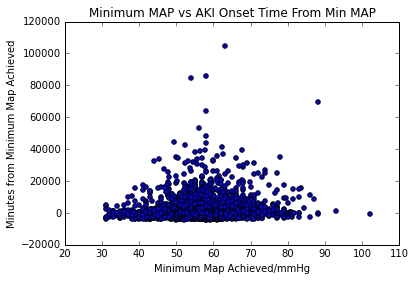

In [38]:
# Scatter plot of minimum map achieved to time of AKI development from time of minimum maps achieved.
for i in range(0, len(akimaptimes)):
    plt.scatter(akimaptimes[i][:,0], akimaptimes[i][:,2]-60*(akimaptimes[i][:,1])) # Non-binned lowest map
    #b=plt.scatter(len(akimaptimes[i])*[10*(i+3)], akimaptimes[i][:,1]) # Binned lowest map
plt.title('Minimum MAP vs AKI Onset Time From Min MAP')
plt.xlabel('Minimum Map Achieved/mmHg')
plt.ylabel('Minutes from Minimum Map Achieved')
plt.show()
